<a href="https://colab.research.google.com/github/utopian18/ML_in_Textile/blob/main/XGBoost_and_ANN_comparison_textile_rejection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_csv('/content/log_transformed_data.csv')

In [4]:
df.head()

,warp_count,weft_count,epi,ppi,beam_type,Finish_order_yds,Deliverd Yds,shrinkage,Total loss%,log_finish_order_yds,log_delivered_yds,log_ppi
0,40,40,110,80,double beam,31300,34668,12.500542,8.665974,10.351373,10.453572,4.382027
1,40,40,110,90,normal,54600,59019,14.500689,14.519973,10.907789,10.985615,4.499810
2,40,40,110,90,normal,64715,70613,14.499654,14.054488,11.077748,11.164970,4.499810
3,40,40,110,90,normal,25500,27820,14.502171,14.011231,10.146434,10.233510,4.499810
4,50,50,100,90,normal,3500,3902,12.005568,10.551219,8.160518,8.269245,4.499810


In [5]:
use_cols = ['warp_count', 'weft_count', 'epi', 'ppi', 'beam_type', 'shrinkage','log_finish_order_yds', 'log_delivered_yds', ]

In [6]:
X = df[use_cols]
y = df['Total loss%']

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X_train,X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)

In [9]:
X_train['beam_type']= X_train['beam_type'].factorize()[0]
X_test['beam_type']= X_test['beam_type'].factorize()[0]


In [10]:
from xgboost import XGBRegressor

In [11]:
xgb = XGBRegressor()

In [12]:
xgb.fit(X_train, y_train)

[09:05:56] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor()

In [13]:
y_pred_xgb = xgb.predict(X_test)

In [14]:
from sklearn.metrics import r2_score

In [15]:
r2_score(y_test, y_pred_xgb)

0.476535482821018

In [16]:
import matplotlib.pyplot as plt

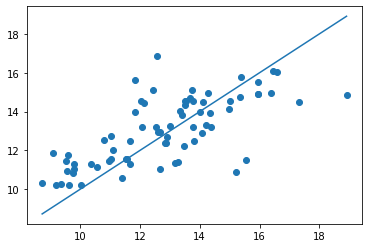

In [24]:
p1 = min(min(y_test), min(y_pred_xgb))
p2 = max(max(y_test), max(y_pred_xgb))
plt.scatter(y_test, y_pred_xgb)
plt.plot([p1,p2], [p1,p2])

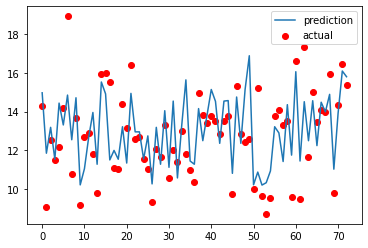

In [28]:
plt.scatter(range(0, len(y_test)),y_test, c='red', label='actual')
plt.plot(y_pred_xgb, label='prediction')
plt.legend()

**ANN Model**

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)

In [30]:
from sklearn.preprocessing import OneHotEncoder

In [31]:
ohe = OneHotEncoder(handle_unknown='ignore')

In [32]:
X_train_enc = ohe.fit_transform(X_train[['beam_type']])
X_test_enc = ohe.transform(X_test[['beam_type']])

In [33]:
X_train_enc = pd.DataFrame(X_train_enc.todense(), columns = ohe.get_feature_names_out())
X_test_enc = pd.DataFrame(X_test_enc.todense(), columns = ohe.get_feature_names_out())

In [34]:
X_train_enc.index = X_train.index
X_test_enc.index = X_test.index

In [35]:
X_train_ohe = pd.concat([X_train, X_train_enc], axis=1)
X_test_ohe = pd.concat([X_test, X_test_enc], axis=1)

In [36]:
X_train_ohe = X_train_ohe.drop('beam_type', axis=1)
X_test_ohe = X_test_ohe.drop('beam_type', axis=1)

In [85]:
X_train_ohe.head()

,warp_count,weft_count,epi,ppi,shrinkage,log_finish_order_yds,log_delivered_yds,beam_type_Double yarn,beam_type_double beam,beam_type_normal
63,40,40,110,70,9.998510,9.210340,9.295600,0.0,0.0,1.0
352,40,40,130,70,16.544697,6.956545,7.045777,0.0,0.0,1.0
255,30,30,100,70,14.601252,7.575585,7.638198,0.0,0.0,1.0
315,40,40,120,100,12.518936,7.003065,7.017506,0.0,0.0,1.0
78,80,80,140,88,12.499824,10.654550,10.739631,1.0,0.0,0.0


In [37]:
from sklearn.preprocessing import MinMaxScaler

In [38]:
sc = MinMaxScaler()

In [39]:
X_train_enc_sc = sc.fit_transform(X_train_ohe)
X_test_enc_sc = sc.transform(X_test_ohe)

In [40]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [41]:
input_layers = keras.Input(shape=(X_train_enc_sc.shape[1], ))
x = keras.layers.Dense(128, activation='relu', kernel_initializer='normal')(input_layers)
x = keras.layers.Dense(256, activation='relu', kernel_initializer='normal')(x)
x = keras.layers.Dense(128, activation='relu', kernel_initializer='normal')(x)
output_layers = keras.layers.Dense(1, activation='relu', kernel_initializer='normal')(x)
model = keras.Model(inputs= input_layers, outputs = output_layers)


In [42]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense (Dense)               (None, 128)               1408      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 67,457
Trainable params: 67,457
Non-trainable params: 0
_________________________________________________________________


In [43]:
model.compile(optimizer='adam', loss='mae',metrics='mae')

In [44]:
from tensorflow.keras.callbacks import EarlyStopping

In [54]:
early_stops = EarlyStopping(monitor='loss', patience=30, mode = 'min')

In [55]:
model.fit(X_train_enc_sc, y_train, epochs=600, batch_size=20, callbacks=[early_stops], verbose=0)

In [56]:
y_pred = model.predict(X_test_enc_sc)

In [57]:
from sklearn.metrics import r2_score

In [58]:
r2_score(y_test, y_pred)

0.44456588320153645

In [59]:
import matplotlib.pyplot as plt


In [60]:
p1 = max(max(y_pred), max(y_test))
p2 = min(min(y_pred), min(y_test))

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


Text(0.5, 1.0, 'ANN prediction')

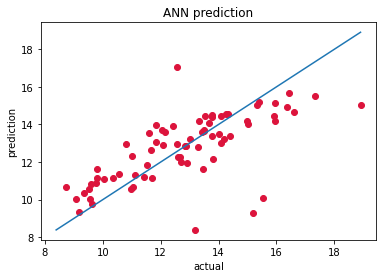

In [61]:
plt.scatter(y_test,y_pred, c= 'crimson')
plt.plot([p1,p2], [p1,p2])
plt.xlabel('actual')
plt.ylabel('prediction')
plt.title('ANN prediction')


Text(0.5, 1.0, 'ANN prediction')

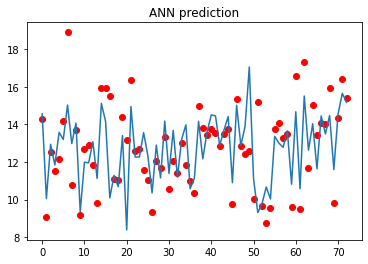

In [63]:
plt.scatter(range(0, len(y_test)), y_test, c='red', label = 'actual')
plt.plot(y_pred)
plt.title('ANN prediction')
